In [19]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv("../../data/processed/sleep_cycle_productivity_cleaned.csv")

In [4]:
# 데이터 타입 및 이진분류 변환
ordered_score = CategoricalDtype(categories=list(range(1, 11)), ordered=True)

df['Sleep Quality'] = df['Sleep Quality'].astype(ordered_score)
df['Productivity Score'] = df['Productivity Score'].astype(ordered_score)
df['Mood Score'] = df['Mood Score'].astype(ordered_score)
df['Stress Level'] = df['Stress Level'].astype(ordered_score)

df['Weekday'] = df['Weekday'].astype('category')
df['Gender'] = df['Gender'].astype('category')


df['Sleep_Quality_Binary'] = (df['Sleep Quality'] >= 5).astype(int)
y = df['Sleep_Quality_Binary']

X = df[['Age', 'Gender', 'Sleep Start Time', 'Sleep End Time',
        'Total Sleep Hours', 'Exercise (mins/day)',
        'Screen Time Before Bed (mins)', 'Work Hours (hrs/day)',
        'Productivity Score', 'Mood Score', 'Stress Level', 'Weekday']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [10]:
X_test.shape

(1000, 12)

### PCA (주성분 분석)

In [5]:
# 전처리: 수치형 표준화 + 범주형 원핫 인코딩
categorical_features = ['Gender', 'Weekday']
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# 전처리 적용
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# PCA 적용 (95% 이상 설명하는 주성분 선택)
pca = PCA(n_components=0.95, random_state=5)
X_train_pca = pca.fit_transform(X_train_preprocessed)
X_test_pca = pca.transform(X_test_preprocessed)

print(f'훈련 데이터 shape (PCA): {X_train_pca.shape}')
print(f'테스트 데이터 shape (PCA): {X_test_pca.shape}')
print(f'선택된 주성분 수: {X_train_pca.shape[1]}')

훈련 데이터 shape (PCA): (4000, 10)
테스트 데이터 shape (PCA): (1000, 10)
선택된 주성분 수: 10


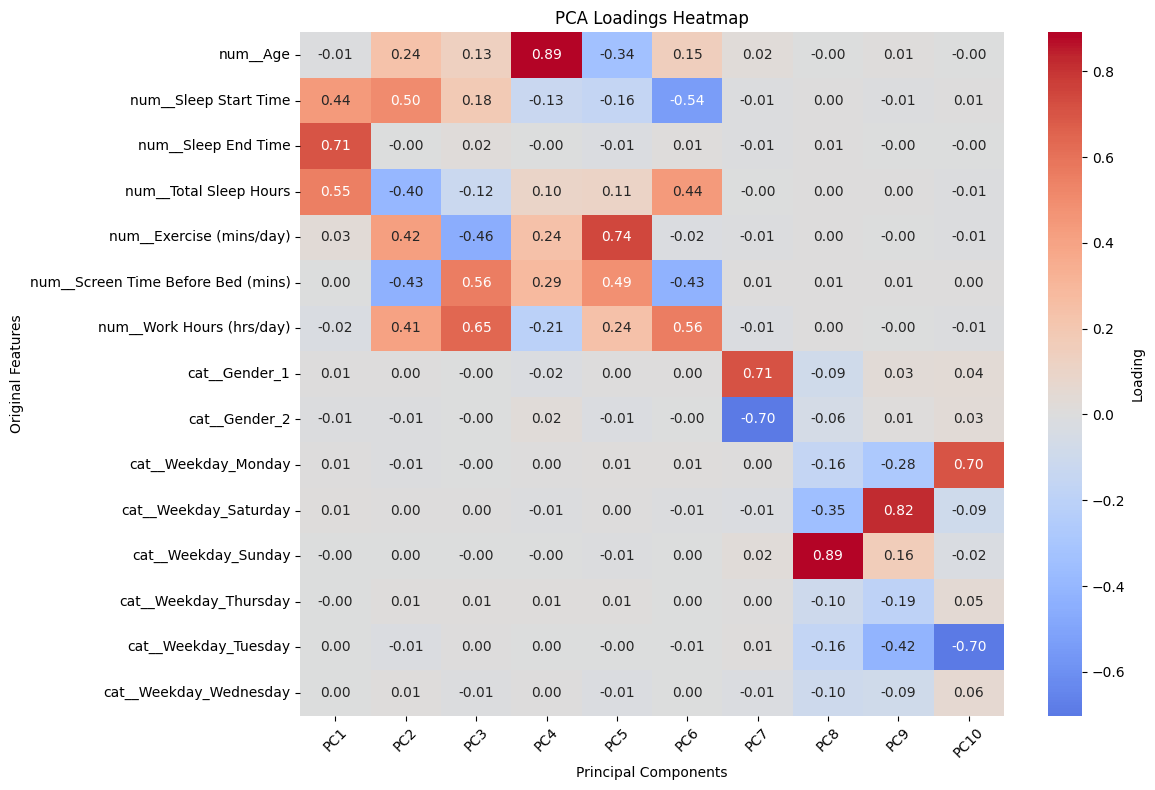

In [13]:
# 주성분 해석, 로딩 행렬 (각 주성분과 원래 변수 간 기여도)
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=preprocessor.get_feature_names_out()
)

# 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(pca_loadings, cmap='coolwarm', center=0, annot=True, fmt=".2f", cbar_kws={'label': 'Loading'})
plt.title('PCA Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

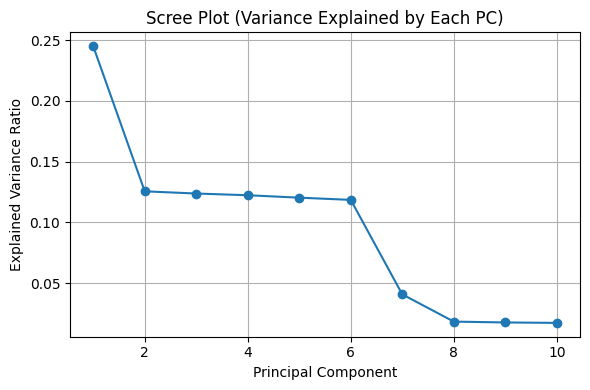

In [18]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1),
         explained_variance, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (Variance Explained by Each PC)')
plt.grid(True)
plt.tight_layout()
plt.show()

### 군집 분석 (주성분 분석 결과 이용)

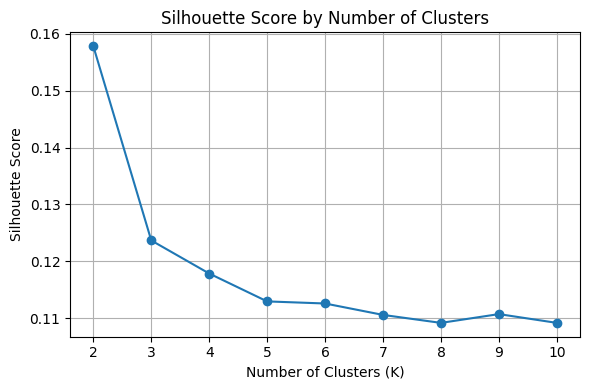

In [20]:
# 군집 수 범위 설정
K_range = range(2, 11)
silhouette_scores = []

# 실루엣 점수 계산
for k in K_range:
    model = KMeans(n_clusters=k, random_state=5, n_init=10)
    labels = model.fit_predict(X_train_pca)
    score = silhouette_score(X_train_pca, labels)
    silhouette_scores.append(score)

# 시각화
plt.figure(figsize=(6, 4))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.grid(True)
plt.tight_layout()
plt.show()

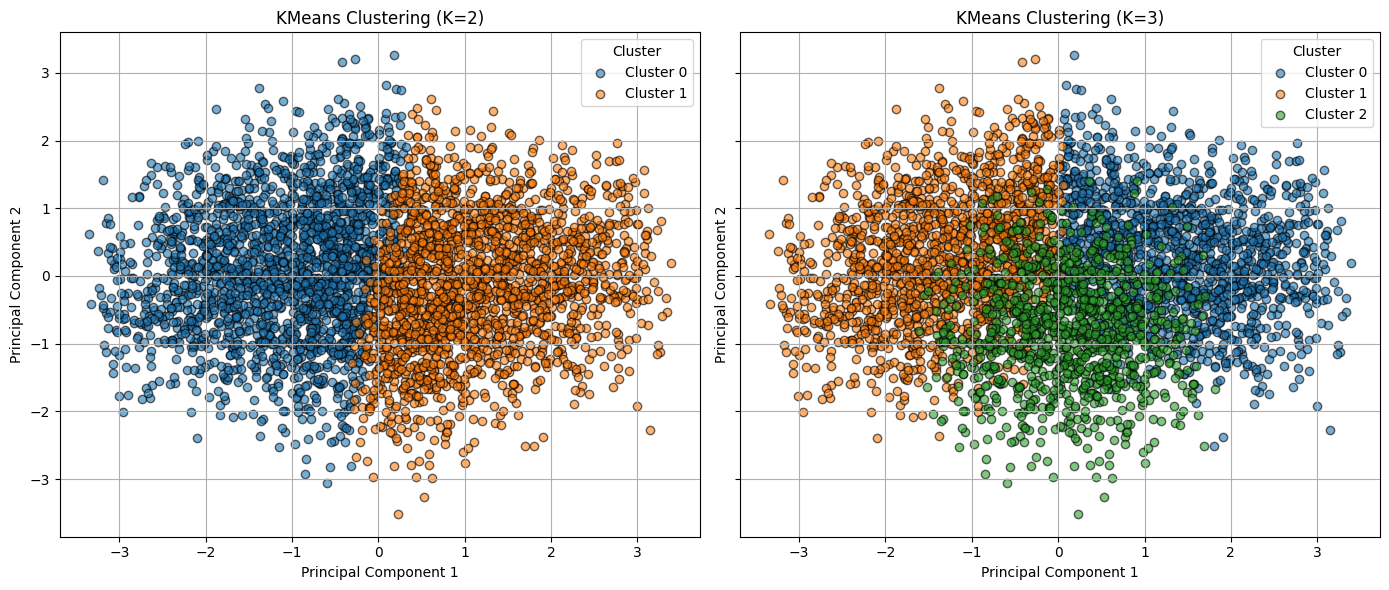

In [22]:
# 군집 수별 모델 정의 및 학습
kmeans_2 = KMeans(n_clusters=2, random_state=5, n_init=10)
labels_2 = kmeans_2.fit_predict(X_train_pca)

kmeans_3 = KMeans(n_clusters=3, random_state=5, n_init=10)
labels_3 = kmeans_3.fit_predict(X_train_pca)

# 색상과 라벨 정의
colors = ['tab:blue', 'tab:orange', 'tab:green']

# 시각화 (2개 subplot)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

for ax, labels, n_clusters, title in zip(
    axes,
    [labels_2, labels_3],
    [2, 3],
    ['KMeans Clustering (K=2)', 'KMeans Clustering (K=3)']
):
    for i in range(n_clusters):
        mask = labels == i
        ax.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1],
                   c=colors[i], label=f'Cluster {i}', alpha=0.6, edgecolor='k')
    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend(title='Cluster')
    ax.grid(True)

plt.tight_layout()
plt.show()

### 주성분 분석, 군집 분석 데이터 저장 (이후 모델에서 활용)

In [23]:
X_full_pca = np.vstack([X_train_pca, X_test_pca])
cluster_full = np.concatenate([kmeans_2.labels_, kmeans_2.predict(X_test_pca)])

pca_df = pd.DataFrame(X_full_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
pca_df['Cluster'] = cluster_full
pca_df['Sleep_Quality_Binary'] = pd.concat([y_train, y_test], ignore_index=True)

pca_df.to_csv('../../data/processed/3_pca_cluster_data.csv', index=False)